# Using matrix-based kernels

We demonstrate the gridding of fields with `cygrid` with a minimal example, using infrared data from the Planck mission. While the image here is only two-dimensional, we note that `cygrid` was designed for spectroscopic HI data, so the handling of the spectral axis is well-supported.

We start by adjusting the notebook settings.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We attempt to limit our dependencies as much as possible, but [`astropy`](https://astropy.readthedocs.org/en/stable/) and [`wcsaxes`](http://wcsaxes.readthedocs.org/en/latest/) needs to be available on your machine if you want to re-run the calculations. Furthermore, scipy is used to produce a comparison with cubic spline filtering. We can highly recommend [`anaconda`](https://www.continuum.io/downloads) as a scientific `python` platform.

In [2]:
import numpy as np
import matplotlib.pyplot as pl

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.utils import NumpyRNGContext

import cygrid

Let's define some plotting `kwargs` for the images.

In [3]:
imkw = dict(
    cmap='viridis_r',
    origin='lower',
    interpolation='nearest')

For our first demonstration, we sample random data and add some point sources.

In [4]:
def setup_data(mapcenter, mapsize, beamsize_fwhm, num_samples, num_sources):
    '''
    Produce test data (including coords) - containing just noise and some point sources.
    
    Note: as in real astronomical measurements, the point sources are convolved with the
          instrument's response function (PSF), or telescope beam.
    '''

    lon_scale = np.cos(np.radians(mapcenter[1]))
    map_l, map_r = (
        mapcenter[0] - 1.1 * mapsize[0] / 2. / lon_scale,
        mapcenter[0] + 1.1 * mapsize[0] / 2. / lon_scale
        )
    map_b, map_t = mapcenter[1] - 1.1 * mapsize[1] / 2., mapcenter[1] + 1.1 * mapsize[1] / 2.
    
    # coordinates are drawn from a uniform distribution
    xcoords = np.random.uniform(map_l, map_r, num_samples).astype(np.float64)
    ycoords = np.random.uniform(map_b, map_t, num_samples).astype(np.float64)

    # add Gaussian noise
    signal = np.random.normal(0., 0.01, len(xcoords))
    
    beamsize_sigma = beamsize_fwhm / np.sqrt(8 * np.log(2))
    
    # put in artifical point source, with random amplitudes
    # we'll assume a Gaussian-shaped PSF
    
    def gauss2d(x, y, x0, y0, A, s):
        return A * np.exp(-((x-x0)**2 + (y-y0)**2) / 2. / s**2)
    
    for _ in range(num_sources):
        
        sou_x = np.random.uniform(map_l, map_r, 1).astype(np.float64)
        sou_y = np.random.uniform(map_b, map_t, 1).astype(np.float64)
        A = np.random.uniform(0, 10, 1)
        signal += gauss2d(xcoords, ycoords, sou_x, sou_y, A, beamsize_sigma)

    signal = signal[:, np.newaxis]  # need dummy spectral axis
    return xcoords, ycoords, signal

In [5]:
mapcenter = 60., 30.  # all in degrees
mapsize = 5., 5.
beamsize_fwhm = 0.01
num_samples = 10 ** 6
num_sources = 20

with NumpyRNGContext(1):
    xcoords, ycoords, signal = setup_data(
        mapcenter, mapsize, beamsize_fwhm, num_samples, num_sources
        )

 Now define a FITS header dictionary, which we can feed to the gridder.

In [6]:
def setup_header(mapcenter, mapsize, beamsize_fwhm):
    '''
    Produce a FITS header that contains the target field.
    '''
    
    # define target grid (via fits header according to WCS convention)
    # a good pixel size is a third of the FWHM of the PSF (avoids aliasing)
#     pixsize = beamsize_fwhm / 3.
    pixsize = beamsize_fwhm / 0.5  # hefty undersampling
    dnaxis1 = int(mapsize[0] / pixsize)
    dnaxis2 = int(mapsize[1] / pixsize)

    header = {
        'NAXIS': 3,
        'NAXIS1': dnaxis1,
        'NAXIS2': dnaxis2,
        'NAXIS3': 1,  # need dummy spectral axis
        'CTYPE1': 'RA---SIN',
        'CTYPE2': 'DEC--SIN',
        'CUNIT1': 'deg',
        'CUNIT2': 'deg',
        'CDELT1': -pixsize,
        'CDELT2': pixsize,
        'CRPIX1': dnaxis1 / 2.,
        'CRPIX2': dnaxis2 / 2.,
        'CRVAL1': mapcenter[0],
        'CRVAL2': mapcenter[1],
        }
    
    return header
    
    
    

In [7]:
target_header = setup_header(mapcenter, mapsize, beamsize_fwhm)

# let's already define a WCS object for later use in our plots:
target_wcs = WCS(target_header)

We start the gridding by initating the gridder with the `target_header`. Prior to this, we need to add a third axis to this header because `cygrid` was designed for three-dimensional data.

In [8]:
gridder = cygrid.WcsGrid(target_header)

The gridding kernel is of key importance for the entire gridding process. `cygrid` allows you to specify the shape of the kernel (e.g. elliptical Gaussian or tapered sinc) and its size.

In our example, we use a symmetrical Gaussian (i.e. the major and minor axis of the kernel are identical). In that case, we need to furthermore specify `kernelsize_sigma`, the `sphere_radius` up to which the kernel will be computed, and the maximum acceptable healpix resolution for which we recommend `kernelsize_sigma/2`.

We refer to section 3.5 of the paper ('a minimal example') for a short discussion of the kernel parameters.

In [9]:
kernelsize_fwhm = beamsize_fwhm / 2.
kernelsize_sigma = kernelsize_fwhm / np.sqrt(8 * np.log(2)) # https://en.wikipedia.org/wiki/Full_width_at_half_maximum
support_radius = 50. * kernelsize_sigma

Now define matrix with a Gaussian kernel

In [10]:
dx, dy = abs(target_header['CDELT1']) / 5., abs(target_header['CDELT2'] / 5.)
print('dx, dy', dx, dy)

# make kernel size odd (for each dimension)
nx = 2 * int(support_radius / dx + 0.5) + 1
ny = 2 * int(support_radius / dy + 0.5) + 1
print('nx, ny', nx, ny)

# put ref pixel exactly in the middle
refpix_x, refpix_y = nx // 2, ny // 2
print('refpix_x, refpix_y', refpix_x, refpix_y)

xvec = (np.arange(nx) - refpix_x) * dx
yvec = (np.arange(ny) - refpix_y) * dy

# print(xcoords, ycoords)

dx, dy 0.004 0.004
nx, ny 55 55
refpix_x, refpix_y 27 27


In [11]:
def gauss_1d(x, y, x0, y0, sigma):
    
    r2 = (x - x0) ** 2 + (y - y0) ** 2
    return np.exp(-r2 / 2. / sigma ** 2)

# gauss_matrix_kernel = gauss_1d(
#     1., xvec[np.newaxis, :], yvec[:, np.newaxis], 
#     refpix_x, refpix_y,
#     kernelsize_sigma,
#     )

# gauss_matrix_kernel = gauss_1d(d, kernelsize_sigma) - gauss_1d(d, 2 * kernelsize_sigma)

# gauss_matrix_kernel = np.zeros((nx, ny)) + 0.01
# gauss_matrix_kernel[refpix_x - 5 : refpix_x] = -1.
# gauss_matrix_kernel[refpix_x + 1 : refpix_x + 5] = 1.

# log spiral:
gauss_matrix_kernel = np.zeros((nx, ny))
a, b, c = 0.004, 1. / 3., 3.4
theta = np.linspace(np.pi / 4., c * 2 * np.pi, 1000)
r = a * np.exp(b * theta)
x0 = r * np.cos(theta)
y0 = r * np.sin(theta)
for _x, _y, _t, _r in zip(x0, y0, theta, r):
    gauss_matrix_kernel += gauss_1d(
        xvec[np.newaxis, :], yvec[:, np.newaxis], 
        _x, _y,
        4 * kernelsize_sigma,
        ) * _r ** 1.2


# not necessary
# gauss_matrix_kernel /= np.nansum(gauss_matrix_kernel)

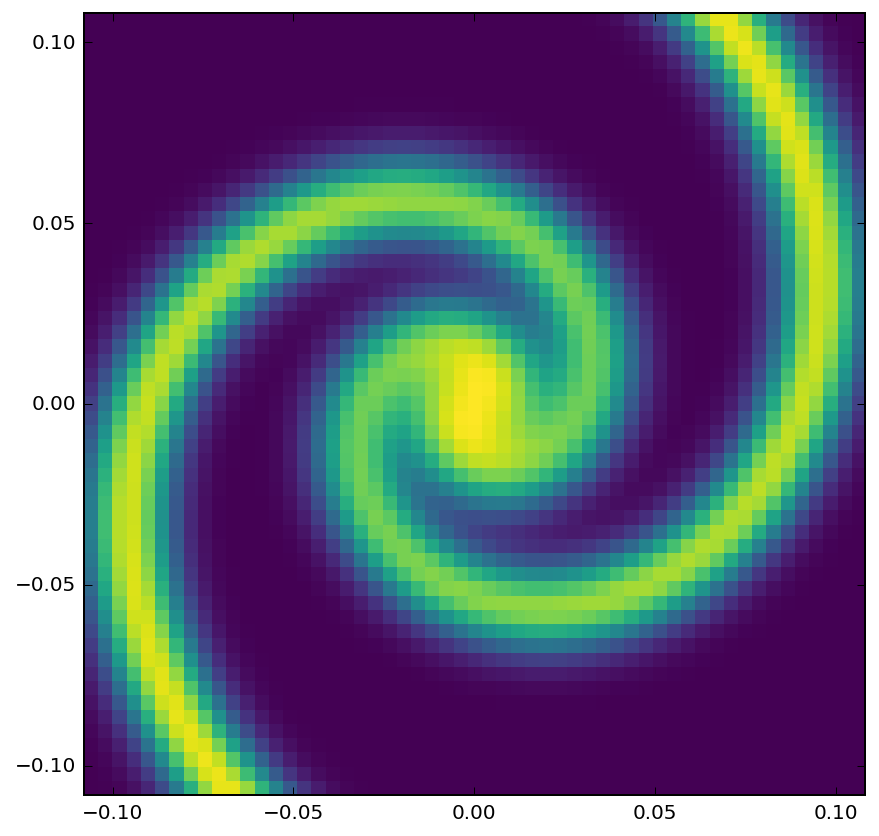

In [12]:
fig = pl.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
# ax.plot(x0 + refpix_x, y0 + refpix_y, 'x')
ax.imshow(
    gauss_matrix_kernel + gauss_matrix_kernel[::-1, ::-1], 
    extent=(xvec[0], xvec[-1], yvec[0], yvec[-1]), 
    origin='lower', cmap='viridis', interpolation='nearest',
    )
ax.set_aspect('equal')
pl.show()

In [13]:
total_kernel = gauss_matrix_kernel + gauss_matrix_kernel[::-1, ::-1]
gridder.set_kernel(
    'matrix2d',
    (total_kernel.T, (refpix_x, refpix_y), (dx, dy)),
    np.sqrt(2.) * support_radius,
    kernelsize_sigma * 2.
    )

After the kernel has been set, we perform the actual gridding by calling `grid()` with the flattened coordinates and the data. Note that we need to add an artifical third axis to the `input_data`.

In [14]:
gridder.grid(xcoords, ycoords, signal)

To get the gridded map, we simply call `get_datacube()`. We get rid of the degenerate third axis by using `squeeze()`.

In [15]:
cygrid_map = gridder.get_datacube().squeeze()

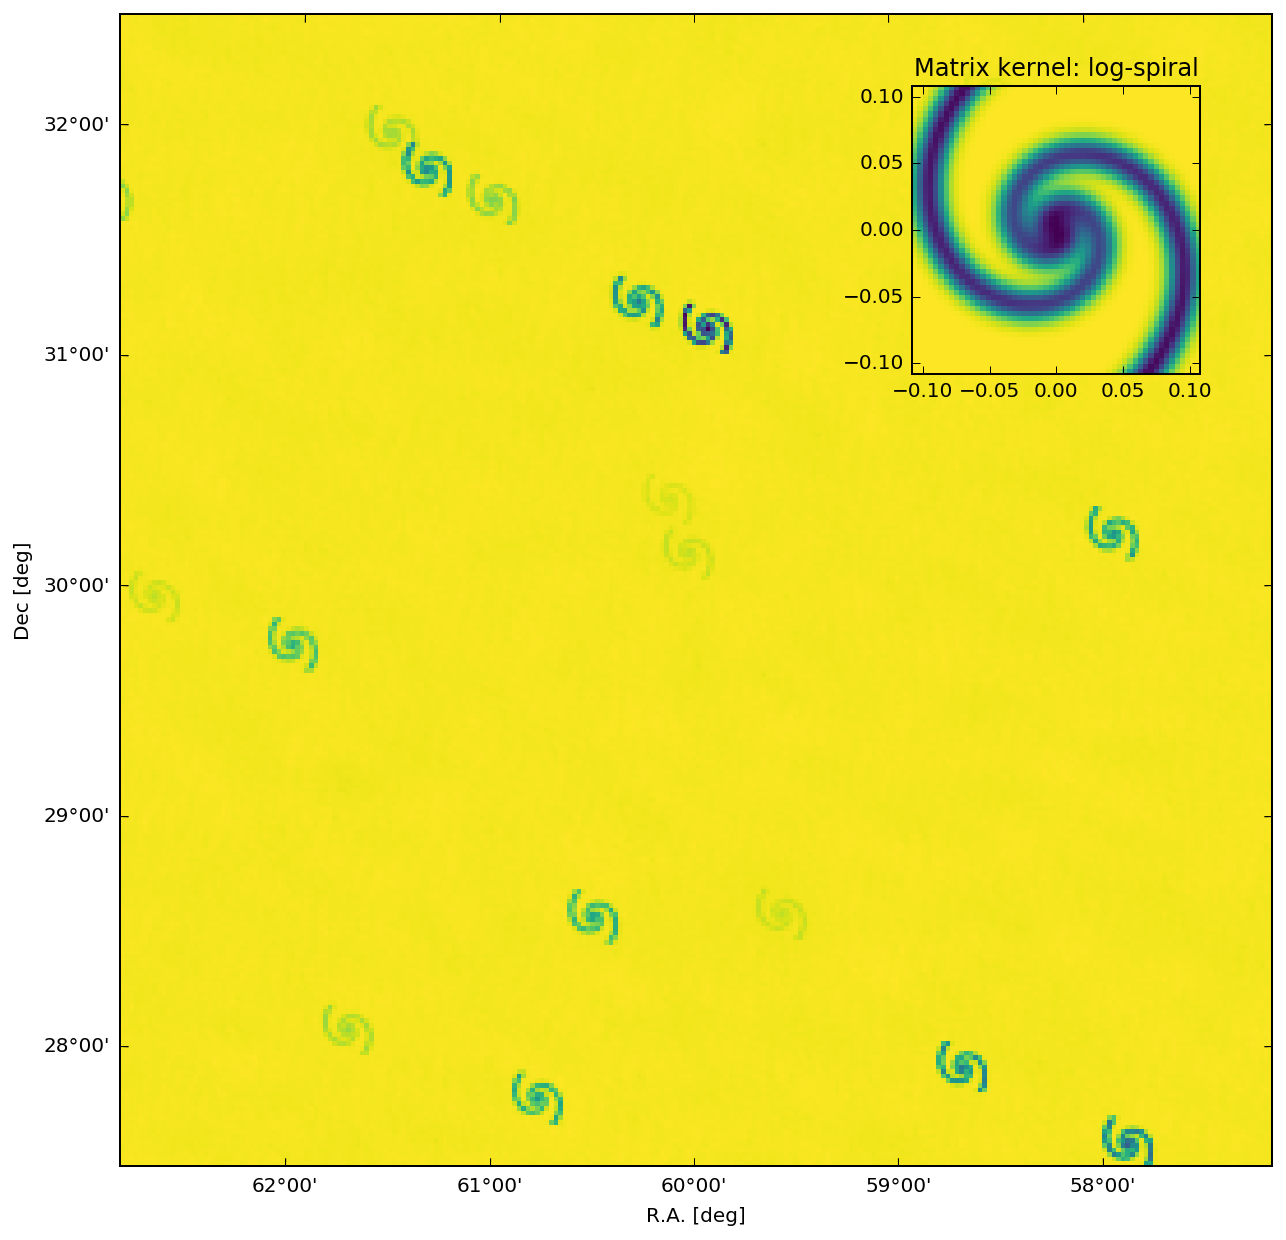

In [18]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8), projection=target_wcs.celestial)
zax = fig.add_axes((0.65, 0.65, 0.2, 0.2))
ax.imshow(cygrid_map, **imkw)  # , vmin=-0.25, vmax=2.0
zax.imshow(
    gauss_matrix_kernel[::-1] + gauss_matrix_kernel[:, ::-1], 
    extent=(xvec[0], xvec[-1], yvec[0], yvec[-1]), 
    **imkw,
    )
zax.set_aspect('equal')
zax.set_title('Matrix kernel: log-spiral')
lon, lat = ax.coords
lon.set_axislabel('R.A. [deg]')
lat.set_axislabel('Dec [deg]')
pl.show()

In [17]:
np.std(np.sort(cygrid_map.flatten())[:int(len(cygrid_map) * 0.85)])

9.7657321e-05